In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import random
from scipy.optimize import curve_fit

from functools import wraps
import time

# Notes 

- big dependence on starting state at low $\beta$: ad vert low $\beta$ is verty hard (very low prob) to add links, since $A \sim \beta^4, \beta^2$ for uniform $+1$ and single $+2$ respectively! Also to destroy a big cycle you gotta build first! We need to add 4 + 4 + 2 new maks to skip a step:
Triple
      +1 
    -------
-1  |     |
    |     | +1    x8 (4 diretctions and inverses) 
    ------- 
       +1  

Swap_a 
      +1 
    -------
-1  |     |
    |     | +1    x4 
    ------- 
       -1  

Swap_b 
      +1 
    -------
-1  |     |
    |     | -1    x2
    ------- 
       +1  


In [103]:
-4 % 2

0

In [2]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time: e} seconds')
        return result
    return timeit_wrapper

def infer_style():
    for style_name, style_params in plt.style.library.items():
        if all(key in plt.rcParams and plt.rcParams[key] == val for key, val in style_params.items()):
            return style_name
    return 'Default'


# add matplotlib style decorator!

In [84]:
# define the state space
# m = (m_r, m_g, m_b) 3 colors
# the grid is from (0,0) to (n,n) make NxN square, each is a 2 dim list, each vertex has an horizontal and vertical edges like so:
#               0
#             ----(x,y)
#                   |    1
#                   |
#
# the 4 directions are encoded as:
#                     0
#                  -------
#             3    |     |   1
#                  |_____|
#                     2
#

class stateSpace:
    def __init__(self, num_colors, grid_size, beta, init = 0, bc = 0, algo = 'metropolis'):  # 'glauber'
    
        self.grid_size = grid_size
        self.V = grid_size**2
        self.num_colors = num_colors
        self.beta = beta
        self.data1 = []
        self.data2 = []
        self.accepted = 0
        self.rejected = 0
        self.loops = 0
        self.algo = algo
        
        self.shape = (num_colors, grid_size+2, grid_size+2, 2)  #the +1 is for free bc  we work only on vertices from  (1,grid_size+1)

        self.grid = 2*random.randint(0, 10, self.shape, dtype=int) if bc == 'random' else bc*np.ones(self.shape, dtype=int)

        if init == 'random':
            self.random_init()
            
        else:
            self.uniform_init(init)

    def random_init(self):
        self.grid[:, 1:-1, 1:-1, :] = 2*np.random.randint(0, 10, size = (self.num_colors, self.grid_size, self.grid_size, 2), dtype=int)

    def uniform_init(self, k):
        self.grid[:, 1:-1, 1:-1, :] = k*np.ones((self.num_colors, self.grid_size, self.grid_size, 2), dtype=int)
        
    def step(self, num_steps = 1):
        print('using {} acceptance probability'.format(self.algo))
        for i in trange(num_steps):
            # choose a random color 
            c = np.random.randint(0, self.num_colors, dtype=int)
         
            # choose a random square
            s = np.random.randint(1, self.grid_size+1, size = 2, dtype=int)

            # get num_link on each side of square s
            S = np.zeros(4, dtype=int)
            S[0] = self.grid[c, s[0], s[1], 0]
            S[2] = self.grid[c, s[0], s[1]-1, 0]
            S[1] = self.grid[c, s[0], s[1], 1]
            S[3] = self.grid[c, s[0]-1, s[1], 1]

            # get list of all possible transformation
            transformations = self.get_possible_transformations(S)
            
            # pick uniformly a transformation
            M = len(transformations)   # num of possible transformation of current state, compute only once! we also need it to compute tha ratio M/M_prime in acceptance_prob
            index = np.random.randint(0, M)  
            X = transformations[index]
            #print('transformation: {}'.format(X))
            
            if self.acceptance_prob(S, M, s, X) >= random.random():
                self.accepted += 1
                if X[0] == -1:
                    self.uniform(c, s, X[1])
                elif X[0] >= 0:
                    self.single(c, s, X[0], X[1])
                else:
                    self.loops += 1
                    self.loop(c, X[0], s)
            else:
                self.rejected += 1

            # store data
            if i % 10_000 == 0:
                self.data1.append(self.get_avg_links())
                #self.data2.append(self.get_max_links())
            
    
    def get_possible_transformations(self, S):
        # list of all possible transformations
        transformations = [(-1, 1), (-1,-1), (0, 2), (0, -2), (1, 2), (1, -2), (2, 2), (2, -2), (3, 2), (3, -2)]                               # (-1,1): uniform +1, (-1,-1): uniform -1, (0,2): single top +2, (0,-2): single top -2, etc...  (-2, 1), (-3, 1) are triple -1 X[0] +2 = direction 
        if S[0] < 2:
            transformations.remove( (0,-2) )
            if S[0] == 0:
                transformations.remove((-1,-1))
        if S[2] < 2:
            transformations.remove((2,-2))
            if S[2] == 0:
                if (-1,-1) in transformations: transformations.remove((-1,-1))
        if S[1] < 2:
            transformations.remove((1,-2))
            if S[1] == 0:
                if (-1,-1) in transformations: transformations.remove((-1,-1))
        if S[3] < 2:
            transformations.remove((3,-2))
            if S[3] == 0:
                if (-1,-1) in transformations: transformations.remove((-1,-1))
        return transformations

    def uniform(self, c, s, n):
        # add +n to top and right
        self.grid[c, s[0], s[1]] += np.array([n, n])

        # add +n to left
        self.grid[c, s[0] - 1, s[1], 1] += n

         # add +n to bottom
        self.grid[c, s[0], s[1] -1, 0] += n

    def single(self, c, s, d, n):
        # left
        if d == 3:
            self.grid[c, s[0]-1, s[1], 1] += n
        # bottom
        elif d == 2:
            self.grid[c, s[0], s[1]-1, 0] += n
        # top and right
        else:
            self.grid[c, s[0], s[1], d] += n
    
    def acceptance_prob(self, S, M, s, X):
        # possible transformation ratio
        S_prime = np.copy(S) 
        if X[0] == -1: # uniform
            S_prime += np.array([X[1], X[1], X[1], X[1]])
        else: #single
            S_prime[X[0]] += X[1]
       


        #get M_prime, the number of possibile transformation of the new state
        M_prime = len(self.get_possible_transformations(S_prime))

        # prob ration 
        if X[0] == -1:
            if X[1] == 1:
                # get local times
                A = self.beta**4 / (16 * (S[0] + 1)*(S[1] + 1)*(S[2] + 1)*(S[3] + 1) 
                                    *(self.num_colors/2 + self.get_local_time(s[0], s[1]))
                                    *(self.num_colors/2 + self.get_local_time(s[0], s[1]-1))
                                    *(self.num_colors/2 + self.get_local_time(s[0]-1 , s[1]))
                                    *(self.num_colors/2 + self.get_local_time(s[0]-1 , s[1]-1))
                                    )
            else:
                # get local times
                A = 16 / (self.beta**4) * S[0]*S[1]*S[2]*S[3] *(self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1 ) - 1)*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]-1) - 1)
        elif X[0] == 0:
            if X[1] == -2:
                A = 4 * S[0]*(S[0]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]) - 1) 
            else:
                A = self.beta**2/ (4*(S[0]+2)*(S[0]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]))  )
        elif X[0] == 1:
            if X[1] == -2:
                A = 4 * S[1]*(S[1]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1) - 1) 
            else:
                A = self.beta**2/ (4*(S[1]+2)*(S[1]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1))  )
        elif X[0] == 2:
            if X[1] == -2:
                A = 4 * S[2]*(S[2]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1 ) - 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1 ) - 1) 
            else:
                A = self.beta**2/ (4*(S[2]+2)*(S[2]+1)*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1))*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1))  )
        elif X[0] == 3:
            if X[1] == -2:
                A = 4 * S[3]*(S[3]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time( s[0]-1, s[1]) - 1)*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1) - 1) 
            else:
                A = self.beta**2/ (4*(S[3]+2)*(S[3]+1)*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]))*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1))  )

        #print('acceptance prob = {}'.format(min(1, M/M_prime * A)))
        return min(1, M/M_prime * A) if self.algo == 'metropolis' else 1/(1+ M_prime/(M*A))   # Metropolis  Glauber       #### May impact performanca a bit, better to edit the code!
    
    def get_local_time(self, x, y):   # we know alreadt the number of links in square s! we are wasting a bit of compute power 
        local_time = 0
        for c in range(self.num_colors):
            local_time += self.grid[c, x, y, 0] + self.grid[c, x, y, 1] + self.grid[c, x, y + 1, 1] + self.grid[c, x + 1, y, 0]
        return local_time

    def get_max_links(self):
        max_links = np.zeros(self.num_colors)
        for c in range(0,self.num_colors):
            for x in range(1,self.grid_size+1):
                for y in range(1,self.grid_size+1):
                    if self.grid[c, x, y, 0] >= max_links[c]:
                        max_links[c] = self.grid[c, x, y, 0]
                    if self.grid[c, x, y, 1] >= max_links[c]:
                        max_links[c] = self.grid[c, x, y, 1]
        return max_links
    
    def get_avg_links(self):
        avg_links = np.zeros(self.num_colors)
        for c in range(self.num_colors):
            avg_links[c] = np.mean(self.grid[c, 1:-1, 1:-1, :])
        return avg_links

    def get_avg_local_time(self):
        total_local_time = 0
        for x in range(1,self.grid_size+1):
            for y in range(1,self.grid_size+1):
                total_local_time += self.get_local_time(x,y)
        return total_local_time / self.V

    def check_state(self):
        for c in range(self.num_colors):
            for x in range(1,self.grid_size+1):
                for y in range(1,self.grid_size+1):
                    if (self.grid[c, x, y, 0] + self.grid[c, x, y, 1] + self.grid[c, x, y + 1, 1] + self.grid[c, x + 1, y, 0]) % 2 != 0:
                        print('###  illegal state!  ###')
                        return False 
        return True 
    def plot_one_color(self, c, cmap, ax, alpha = 1.0):
        for x in range(0, self.grid_size+2):
                for y in range(0, self.grid_size+2):
                    # horizontal
                    if self.grid[c,x,y,0] != 0:
                        edge_color = cmap(self.grid[c,x,y,0])
                        ax.plot([x-1, x], [y, y], color=edge_color,linewidth=1.5, alpha = alpha)
                    # vertical
                    if self.grid[c,x,y,1] != 0:   
                        edge_color = cmap(self.grid[c,x,y,1])
                        ax.plot([x, x], [y, y-1], color=edge_color, linewidth=1.5, alpha = alpha)
        

    def plot_grid(self, figsize=(12, 12), colorbar = True, file_name = None):                                              ###### terrible ######
        fig, axes = plt.subplots(1,self.num_colors,figsize = figsize, gridspec_kw={'hspace': 0.05, 'wspace': 0.05}) #, facecolor='black')
        # Adjust the space between subplots
        for c in range(self.num_colors):
            # Define a colormap
            num_segments = int(self.get_max_links()[c]+1)            #color dependet!
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            self.plot_one_color(c, cmap, axes[c])
            #axes[c].set_title('avg links = {}'.format(self.get_avg_links()[c]))
            axes[c].set_xlim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            axes[c].set_ylim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            #axes[c].axis('square')
            axes[c].axis('off')
            
            # Add colorbar
            if colorbar:
                # Add colorbar
                cbar = plt.colorbar(sm, ax=axes[c])
                cbar.set_ticks(  0.5 + np.arange(0, num_segments,1))
                cbar.set_ticklabels(list(range(0, num_segments)))
                #cbar.set_label('Color Mapping')

        fig.suptitle(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()

    def plot_overlap(self, figsize = (12,12), normalized = False, file_name = None):
        # Create a figure and axes
        fig, ax = plt.subplots(figsize = figsize)

        for c in range(self.num_colors):
            # Define a colormap
            num_segments = int(self.get_max_links()[c]+1) if not normalized else 2
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            self.plot_one_color(c, cmap, ax, 0.6)
            ax.set_title(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
            ax.set_xlim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            ax.set_ylim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            #ax.axis('square')
            ax.axis('off')
    
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()
    
    
def create_cmap(color, n_bins):
    # get current style
    current_style = infer_style()
    start = (0,0,0) if current_style == 'dark_background' else (1,1,1)
    if color == 0:
        colors = [start, (1, 0, 0)]  # RGB values  
    if color == 1:
        colors = [start, (0, 1, 0)]  # RGB values
    if color == 2:
        colors = [start, (0, 0, 1)]  # RGB values

    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=n_bins)
    return cmap


using glauber acceptance probability


  0%|          | 0/10000000 [00:00<?, ?it/s]

average number of links: 0.061279296875
max number of links: 2.0
avg local time: 0.9814453125
steps = 1e+07   acceptance ratio = 0.002681


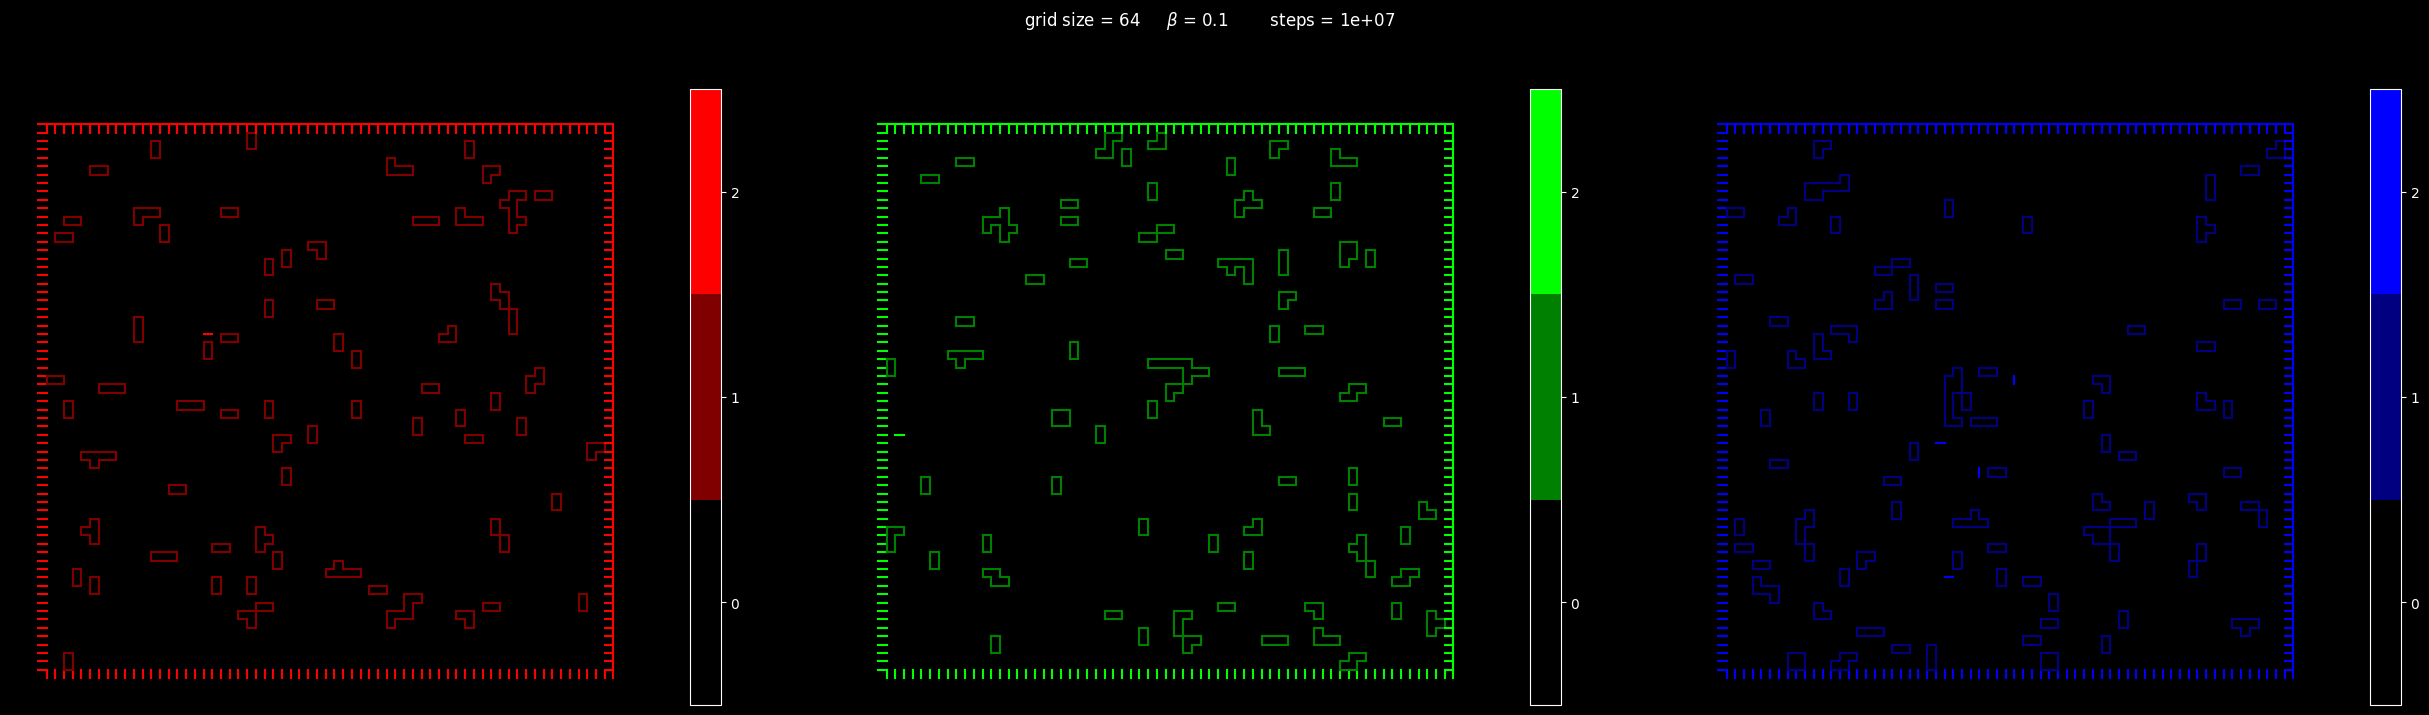

CPU times: total: 4min 18s
Wall time: 4min 39s


In [102]:
%%time 
m = stateSpace(num_colors = 3, grid_size = 64, beta = 0.1, init = 2, bc = 2, algo='glauber')  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False)  #0.1875
m.step(10_000_000)
print('average number of links: {}'.format(m.get_avg_links()[0]))
print('max number of links: {}'.format(m.get_max_links()[0]))
print('avg local time: {}'.format(m.get_avg_local_time()))
print('steps = {:g}   acceptance ratio = {:.6f}'.format(m.accepted + m.rejected, m.accepted / (m.accepted + m.rejected)))

plt.style.use("dark_background") # 'dark_background’
m.plot_grid((32,8), colorbar=True) #, file_name = '64_0_9_U2.pdf')

In [97]:
m.check_state()

True

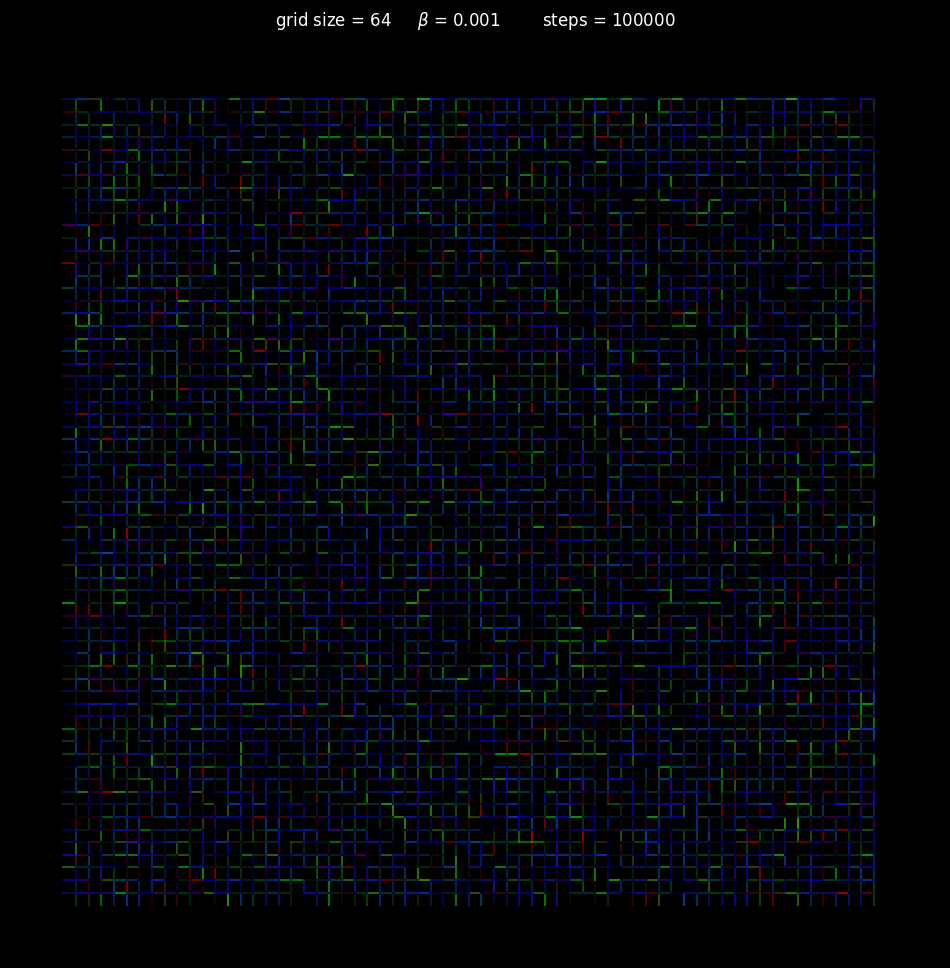

In [68]:
plt.style.use("dark_background")
m.plot_overlap()

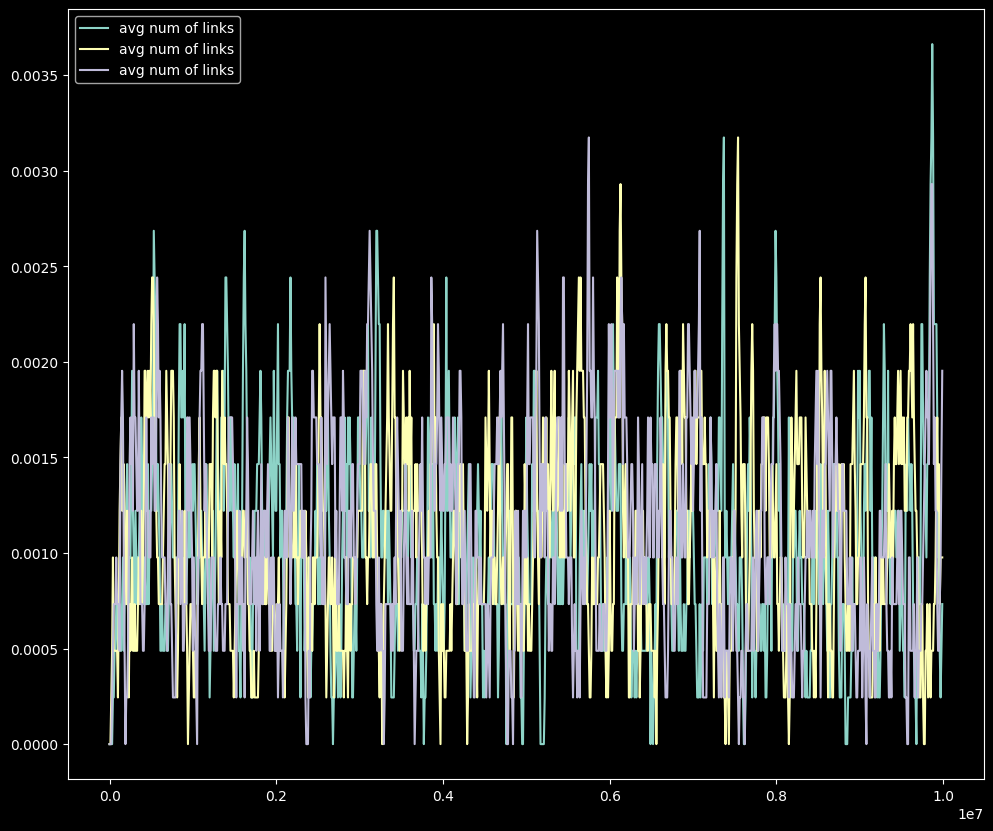

In [101]:
plt.figure(figsize=(26,10))
plt.subplot(1,2,1)
plt.plot( 10_000*np.array(range(0,len(m.data1))) , m.data1, label= 'avg num of links')
plt.legend()

# Animations

In [113]:
# continuous version of square transformation
from ipywidgets import interact, widgets

plt.style.use("default")


# Define your original curve function
def original_curve(t):
    # Example: a parametric equation for a circle
    x = np.cos(2 * np.pi * t)
    y = np.sin(2 * np.pi * t)
    return x, y

# Create the interactive plot function
def plot_curve(scale_factor):
    # Get the original curve points
    t = np.linspace(0, 1, 1000)
    x, y = original_curve(t)

    # Scale the curve based on the slider value
    scaled_x = x * scale_factor
    scaled_y = y * scale_factor

    # Plot the scaled curve without axis but with grid
    plt.figure(figsize=(8, 8))
    plt.plot(scaled_x, scaled_y, label=f'Scale Factor: {scale_factor:.2f}')
    plt.title('Interactive Scaled Curve')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim((-1.1, 1.1))
    plt.ylim((-1.1, 1.1))
    # Turn off the axis
    #plt.axis('off')

    # Show the grid
    plt.axis('off')
    # Add manual grid lines
    for l in range()
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

# Create the interactive slider
slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.01, description='Scale Factor')

# Connect the slider to the plot function
interact(plot_curve, scale_factor=slider)

interactive(children=(FloatSlider(value=1.0, description='Scale Factor', max=1.0, step=0.01), Output()), _dom_…

<function __main__.plot_curve(scale_factor)>